# 1. Trying Tensor cell 2 cell - Obtaining patterns of cell-cell communication with Tensor-cell2cell¶

### 1.1 Libraries

In [1]:
import cell2cell as c2c
import scanpy as sc

import numpy as np
import pandas as pd

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/astear/pkgs/miniforge3/envs/CellPhoneDB/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1.2 Load Data 

In [3]:
import os

data_folder = './'
directory = os.fsencode(data_folder)

output_folder = './results/'
if not os.path.isdir(output_folder):
    os.mkdir(output_folder)

Set the date you wish to analyse, let's start with Lung sample

In [6]:
path_L1_1 = "/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium/xenium_objs/anndata/lung_L1_1.h5ad"

rnaseq = sc.read_h5ad(path_L1_1)

#### Getting a Ligand Receptor Database -> CellChat

In [13]:
lr_pairs = pd.read_csv('https://raw.githubusercontent.com/LewisLabUCSD/Ligand-Receptor-Pairs/master/Human/Human-2020-Jin-LR-pairs.csv')
lr_pairs = lr_pairs.astype(str)

In [25]:
# The vignette mentions we need to have the same names for our expression table for the genes, Is this the case ? 

int_columns = ('ligand_symbol', 'receptor_symbol')

### 1.3 Data Preprocessing

#### 1.3.1 RNA-seq¶

In [47]:
#Adapted this context dictionnary (originially for diagnosis of the samples sick / control), to cell type. 

context_dict = dict()

for diag, df in rnaseq.obs.groupby('singler_annotation'):
    for donor in df['orig.ident'].unique():
        context_dict[donor] = diag

/tmp/ipykernel_351321/2353963009.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for diag, df in rnaseq.obs.groupby('singler_annotation'):


In [48]:
context_dict

{'L1': 'Tu_L1_SFTPB'}

In [49]:
context_names = list(context_dict.keys())

#### Generate list of RNA-seq data aggregated into cell type

In [54]:
rnaseq_matrices = []

# Iteraty by sample/context
for context in tqdm(context_names):
    # Obtain metadata for context
    meta_context = rnaseq.obs.loc[rnaseq.obs['orig.ident'] == context].copy()
    # Single cells in the context
    cells = list(meta_context.index)

100%|██████████| 1/1 [00:00<00:00, 90.99it/s]


In [55]:
meta_context

,orig.ident,nCount_originalexp,nFeature_originalexp,cell_id,x_centroid,y_centroid,transcript_counts,control_probe_counts,control_codeword_counts,unassigned_codeword_counts,...,subsets_Mito_percent,total,libsize_drop,sizeFactor,nCount_SCT,nFeature_SCT,SCT_snn_res.0.8,seurat_clusters,singler_annotation,ident
L1_1_aaaajpka-1,L1,330.0,58,L1_1_aaaajpka-1,1270.714355,2549.835205,330,0,0,0,...,0.0,330.0,False,3.078942,86.0,30,0,0,Tu_L1_SFTPB,0
L1_1_aaaalfpg-1,L1,459.0,62,L1_1_aaaalfpg-1,1273.005737,2539.648682,459,0,0,0,...,0.0,459.0,False,4.282529,87.0,33,2,2,Tu_L1_SFTPB,2
L1_1_aaabioof-1,L1,244.0,49,L1_1_aaabioof-1,1281.513184,2559.730957,245,0,0,0,...,0.0,245.0,False,2.276551,87.0,30,0,0,Tu_L1_SFTPB,0
L1_1_aaafigff-1,L1,560.0,62,L1_1_aaafigff-1,1282.873901,2531.250488,560,0,0,0,...,0.0,560.0,False,5.224871,81.0,29,2,2,Tu_L1_SFTPB,2
L1_1_aaagflfb-1,L1,162.0,40,L1_1_aaagflfb-1,1287.822388,2548.740723,162,0,0,0,...,0.0,162.0,False,1.511481,93.0,37,0,0,Tu_L1_SFTPB,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
L1_1_oinblanj-1,L1,162.0,53,L1_1_oinblanj-1,2748.684326,1318.817627,162,0,0,0,...,0.0,162.0,False,1.511481,98.0,49,1,1,Fibroblasts,1
L1_1_oinccfpo-1,L1,117.0,41,L1_1_oinccfpo-1,2741.356689,1318.515381,117,0,0,0,...,0.0,117.0,False,1.091625,94.0,41,1,1,Tu_L1_SFTPB,1
L1_1_oindepla-1,L1,59.0,34,L1_1_oindepla-1,2764.795654,1324.203247,59,0,0,0,...,0.0,59.0,False,0.550478,70.0,34,5,5,DC_activated,5
L1_1_oineakca-1,L1,75.0,44,L1_1_oineakca-1,2794.730713,1337.239136,75,0,0,0,...,0.0,75.0,False,0.699760,76.0,44,1,1,Macrophages,1


In [58]:
rnaseq_matrices = []

# Iteraty by sample/context
for context in tqdm(context_names):
    # Obtain metadata for context
    meta_context = rnaseq.obs.loc[rnaseq.obs['orig.ident'] == context].copy()
    # Single cells in the context
    cells = list(meta_context.index)

    # Rename index name to identify the barcodes when aggregating expression
    meta_context.index.name = 'barcode'

    # Subset RNAseq data by the single cells in the sample/context
    tmp_data = rnaseq[cells]

    # Keep genes in each sample with at least 4 single cells expressing it
    genes = sc.pp.filter_genes(tmp_data, min_cells=4, inplace=False)[0]
    tmp_data = tmp_data.to_df().loc[:, genes]

    # Aggregate gene expression of single cells into cell types
    exp_df = c2c.preprocessing.aggregate_single_cells(rnaseq_data=tmp_data,
                                                      metadata=meta_context,
                                                      barcode_col='barcode',
                                                      celltype_col='singler_annotation',
                                                      method='nn_cell_fraction',
                                                     )

    rnaseq_matrices.append(exp_df)

100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


In [59]:
# Change gene names to ensembl (here they are annotated as ENSEMBL|SYMBOL)
matrices = []
for rna in rnaseq_matrices:
    tmp = rna.copy()
    tmp.index = [idx.split('|')[0] for idx in rna.index]
    matrices.append(tmp)

#### LR Pairs

In [60]:
lr_pairs = c2c.preprocessing.ppi.remove_ppi_bidirectionality(ppi_data=lr_pairs, 
                                                             interaction_columns=int_columns
                                                             )

Removing bidirectionality of PPI network


In [61]:
lr_pairs.shape

(1988, 17)

In [62]:
ensembl_symbol = dict()

for idx, row in lr_pairs.iterrows():
    ensembl_symbol[row['interaction_ensembl']] = row['interaction_symbol']

In [63]:
ppi_functions = dict()

for idx, row in lr_pairs.iterrows():
    ppi_label = row[int_columns[0]] + '^' + row[int_columns[1]]
    ppi_functions[ppi_label] = row['annotation']

In [64]:
ensembl_symbol = dict()

for idx, row in lr_pairs.iterrows():
    ensembl_symbol[row['interaction_ensembl']] = row['interaction_symbol']

## 4.1 Tensor-cell2cell Analysis

In [65]:
tensor = c2c.tensor.InteractionTensor(rnaseq_matrices=matrices,
                                      ppi_data=lr_pairs,
                                      context_names=context_names,
                                      how='inner',
                                      complex_sep='&',
                                      interaction_columns=('ligand_ensembl', 'receptor_ensembl'),
                                      communication_score='expression_mean',
                                     )

Getting expression values for protein complexes
Building tensor for the provided context


In [66]:
tensor.tensor.shape

(1, 0)

In [67]:
# Put LR pair names from ensembl to symbol
tensor.order_names[1] = [ensembl_symbol[lr] for lr in tensor.order_names[1]]

In [68]:
meta_tf = c2c.tensor.generate_tensor_metadata(interaction_tensor=tensor,
                                              metadata_dicts=[context_dict, ppi_functions, None, None],
                                              fill_with_order_elements=True
                                             )

AssertionError: metadata_dicts should be of the same size as the number of orders/dimensions in the tensor

# 2. Tensor Cell2cell - Inspecting CCC patterns from spatial transcriptomics

Can I finish this part ? 

## 2.1 Setups

In [1]:
import cell2cell as c2c

import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq
import liana as li

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.spatial.distance import squareform

from tqdm.auto import tqdm

%matplotlib inline

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/astear/pkgs/miniforge3/envs/CellPhoneDB/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/astear/pkgs/miniforge3/envs/CellPhoneDB/lib/python3.11/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.


In [2]:
import warnings
warnings.filterwarnings('ignore')

## 2.2 Data

In [3]:
path_L1_1 = "/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium/xenium_objs/anndata/lung_L1_1.h5ad"

adata_L1_1 = sc.read_h5ad(path_L1_1)

In [4]:
adata_L1_1

AnnData object with n_obs × n_vars = 72666 × 271
    obs: 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'sample_id', 'sum', 'detected', 'subsets_Mito_sum', 'subsets_Mito_detected', 'subsets_Mito_percent', 'total', 'libsize_drop', 'sizeFactor', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.8', 'seurat_clusters', 'singler_annotation', 'ident'
    uns: 'X_name'
    obsm: 'PCA', 'TSNE', 'UMAP'
    layers: 'logcounts'

In [22]:
# I skip the normalizing step as this is already done

In [5]:
# Setting up the obsm : "spatial" using the x and y centroid coordinates in .obs
adata_L1_1.obsm['spatial'] = adata_L1_1.obs[['x_centroid', 'y_centroid']].to_numpy()

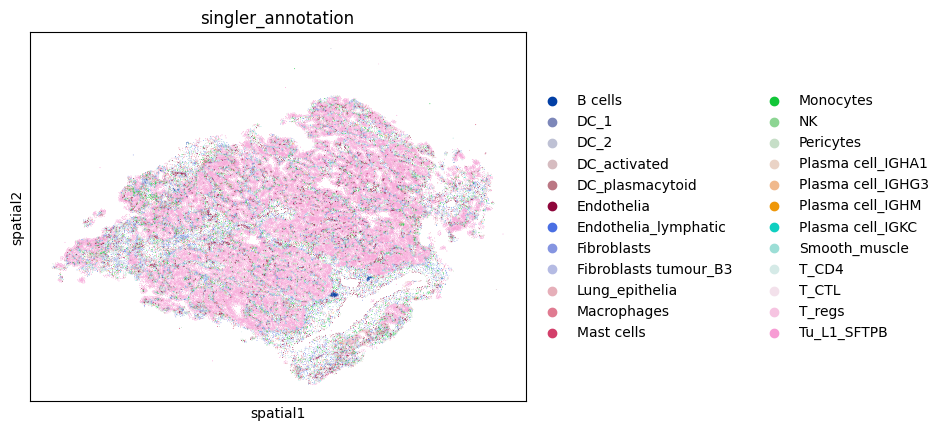

In [6]:
#For printing the anndata object from Marianna. 
sc.pl.embedding(adata_L1_1, basis="spatial", color='singler_annotation')

### Example data of the vignette

In [7]:
#get data
adata = sc.read("kuppe_heart19.h5ad", backup_url='https://figshare.com/ndownloader/files/41501073?private_link=4744950f8768d5c8f68c')

#Normalise
adata.layers['counts'] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

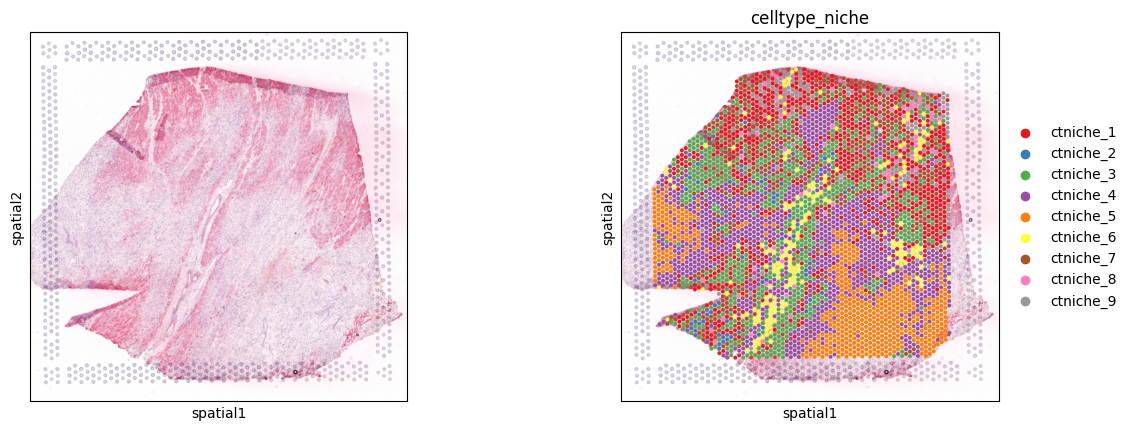

In [31]:
sq.pl.spatial_scatter(adata, color=[None, 'celltype_niche'], size=1.3, palette='Set1')

In [32]:
# Rename to more informative names
full_names = {'Adipo': 'Adipocytes',
              'CM': 'Cardiomyocytes',
              'Endo': 'Endothelial',
              'Fib': 'Fibroblasts',
              'PC': 'Pericytes',
              'prolif': 'Proliferating',
              'vSMCs': 'Vascular_SMCs',
              }
# but only for the ones that are in the data
adata.obsm['compositions'].columns = [full_names.get(c, c) for c in adata.obsm['compositions'].columns]

In [33]:
comps = li.ut.obsm_to_adata(adata, 'compositions')

In [34]:
comps.var

""
Adipocytes
Cardiomyocytes
Endothelial
Fibroblasts
Lymphoid
Mast
Myeloid
Neuronal
Pericytes
Proliferating


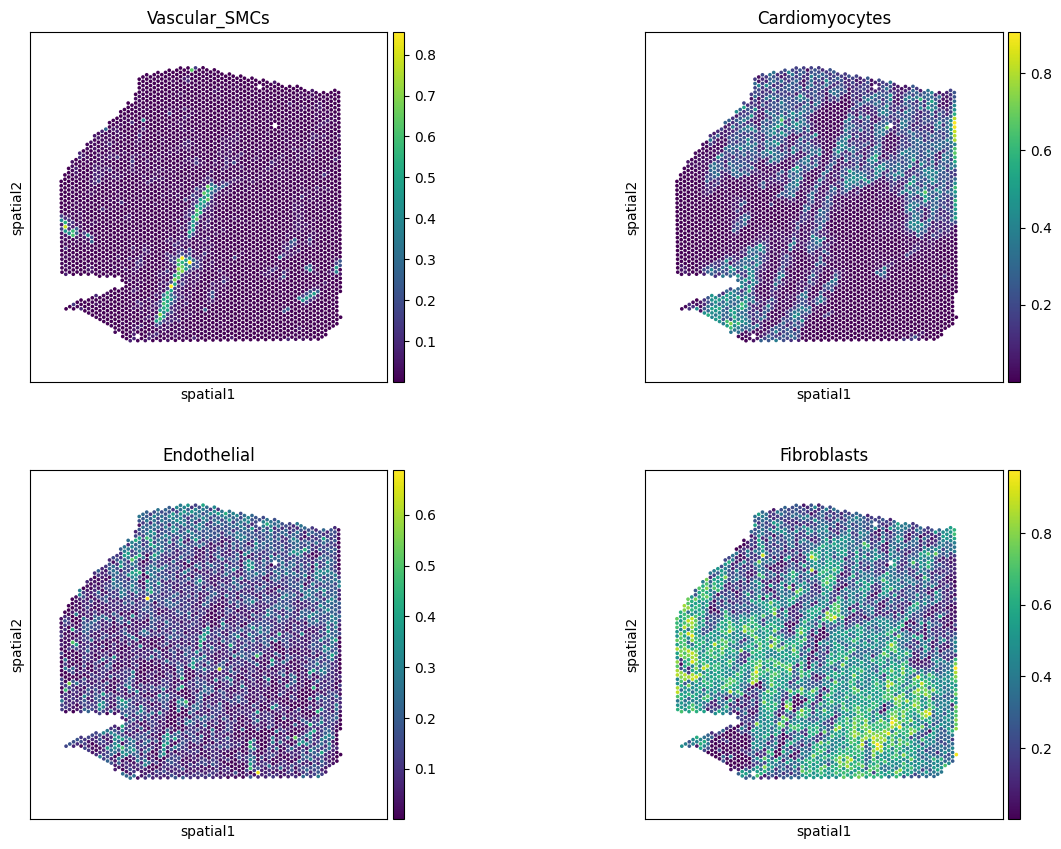

In [36]:
# check key cell types
sq.pl.spatial_scatter(comps,
                      color=['Vascular_SMCs','Cardiomyocytes',
                             'Endothelial', 'Fibroblasts'],
                      size=1.3, ncols=2, img_alpha=0
                      )

In [37]:
adata_og = adata.copy()

In [44]:
adata

AnnData object with n_obs × n_vars = 4113 × 17703
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'celltype_niche', 'molecular_niche', 'grid_x', 'grid_y', 'grid_cell'
    var: 'gene_ids', 'feature_types', 'genome', 'SYMBOL', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'rps', 'mrp', 'rpl', 'duplicated'
    uns: 'spatial', 'log1p', 'celltype_niche_colors'
    obsm: 'compositions', 'mt', 'spatial'
    layers: 'counts'

In [41]:
adata_og

AnnData object with n_obs × n_vars = 4113 × 17703
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'celltype_niche', 'molecular_niche'
    var: 'gene_ids', 'feature_types', 'genome', 'SYMBOL', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'rps', 'mrp', 'rpl', 'duplicated'
    uns: 'spatial', 'log1p', 'celltype_niche_colors'
    obsm: 'compositions', 'mt', 'spatial'
    layers: 'counts'

In [54]:
adata.uns['spatial']['Visium_19_CK297']

{'images': {'hires': array([[[0.99607843, 0.99607843, 0.99607843],
          [0.99607843, 0.99607843, 0.99607843],
          [0.99607843, 0.99607843, 0.99607843],
          ...,
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ]],
  
         [[0.99607843, 0.99607843, 0.99607843],
          [0.99607843, 0.99607843, 0.99607843],
          [0.99607843, 0.99607843, 0.99607843],
          ...,
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ]],
  
         [[1.        , 1.        , 0.99607843],
          [0.99607843, 0.99607843, 0.99607843],
          [0.99607843, 0.99607843, 0.99607843],
          ...,
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ]],
  
         ...,
  
         [[0.99607843, 0.99607843, 0.996078

### 2.2.2 Defining spatial contexts in the tissue 

In [8]:
num_bins = 5

In [ ]:
# What does this do ? Can I modifiy it o have different degress of TU  cells distances from the LB cells ? That way I can use the distance of cells between each other as the context. 

In [10]:
c2c.spatial.create_spatial_grid(adata_mine, num_bins=num_bins)

... storing 'grid_cell' as categorical


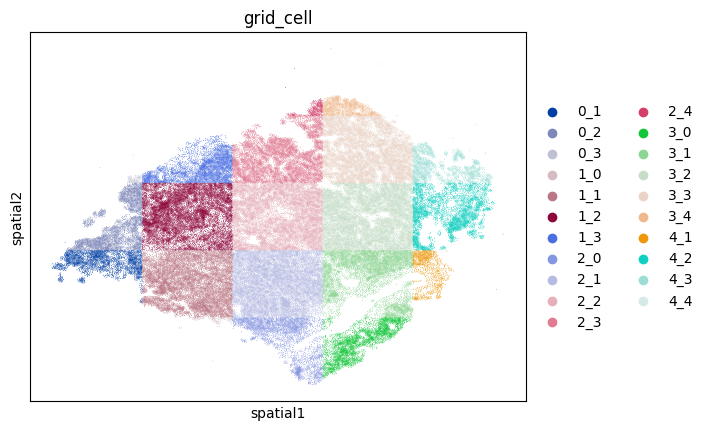

In [11]:
#For printing the anndata object from Marianna. 
sc.pl.embedding(adata_mine, basis="spatial", color='grid_cell')

In [1]:
#On a pas celle-ci : image
#adata_mine.uns['spatial'] = {'test':{'images':{'hires':image}}}

In [7]:
#Can't rememebr what this did
sq.pl.spatial_scatter(adata_mine, color='transcript_counts', palette='tab20')

NameError: name 'sq' is not defined

## 2.3 Tensor-cell2cell Analysis

In [75]:
lr_pairs = pd.read_csv('https://raw.githubusercontent.com/LewisLabUCSD/Ligand-Receptor-Pairs/master/Human/Human-2020-Jin-LR-pairs.csv')

In [112]:
# interaction columns:
# int_columns = ('ligand_symbol', 'receptor_symbol')
int_columns = ('ligand', 'receptor')

In [113]:
lr_pairs = c2c.preprocessing.ppi.remove_ppi_bidirectionality(ppi_data=lr_pairs, 
                                                             interaction_columns=int_columns
                                                             )

Removing bidirectionality of PPI network


In [114]:
ppi_functions = dict()

for idx, row in lr_pairs.iterrows():
    ppi_label = row[int_columns[0]] + '^' + row[int_columns[1]]
    ppi_functions[ppi_label] = row['annotation']

In [115]:
meta = adata_mine.obs.copy()
contexts = sorted(meta['grid_cell'].unique())
context_dict = dict()

for context in contexts:
    if ('0' in context) or (f'{num_bins-1}' in context):
        context_dict[context] = 'border'
    else:
        context_dict[context] = 'center'

In [116]:
contexts = sorted(meta['grid_cell'].unique())
context_dict = dict()

for context in contexts:
    if ('0' in context) or (f'{num_bins-1}' in context):
        context_dict[context] = 'border'
    else:
        context_dict[context] = 'center'

context_names = contexts

In [117]:
rnaseq_matrices = []

for context in tqdm(context_names):
        meta_context = meta.loc[meta['grid_cell'] == context]
        cells = list(meta_context.index)
        
        meta_context.index.name = 'barcode'
        tmp_data = adata_mine[cells]
        # Keep genes in each sample with at least 3 single cells expressing it
        sc.pp.filter_genes(tmp_data, min_cells=3)
        
        # Aggregate gene expression of single cells into cell types
        exp_df = c2c.preprocessing.aggregate_single_cells(rnaseq_data=tmp_data.to_df(),
                                                          metadata=meta_context,
                                                          barcode_col='cell_id',
                                                          celltype_col='singler_annotation',
                                                          method='nn_cell_fraction',
                                                         )
        
        rnaseq_matrices.append(exp_df)

100%|██████████| 21/21 [00:00<00:00, 23.93it/s]


In [118]:
tensor = c2c.tensor.InteractionTensor(rnaseq_matrices=rnaseq_matrices[1:-1],
                                      ppi_data=lr_pairs,
                                      context_names=context_names[1:-1],
                                      how='outer',
                                      outer_fraction=1/4.,
                                      complex_sep='&',
                                      interaction_columns=int_columns,
                                      communication_score='expression_mean',
                                     )

Automatic pdb calling has been turned OFF
Getting expression values for protein complexes
Building tensor for the provided context


In [120]:
meta_tf = c2c.tensor.generate_tensor_metadata(interaction_tensor=tensor,
                                              metadata_dicts=[context_dict, ppi_functions, None, None],
                                              fill_with_order_elements=True
                                             )

In [121]:
tensor.compute_tensor_factorization(rank=8, # tensor.rank # use this instead if you
                                    init='svd', # If it outputs a memory error, replace by 'random'
                                    random_state=888)

In [124]:
fig, axes = c2c.plotting.tensor_factors_plot(interaction_tensor=tensor,
                                             metadata = meta_tf,
                                             sample_col='Element',
                                             group_col='Category',
                                             meta_cmaps=cmaps,
                                             fontsize=14,
                                             filename=None # Put a path (e.g. ./TF.png) to save the figure
                                            )

NameError: name 'cmaps' is not defined

> /tmp/ipykernel_2421536/3948466301.py(5)<module>()
      3                                              sample_col='Element',
      4                                              group_col='Category',
----> 5                                              meta_cmaps=cmaps,
      6                                              fontsize=14,
      7                                              filename=None # Put a path (e.g. ./TF.png) to save the figure



ipdb>  c


In [2]:
# %pdb à regarder, permet de faciliter le debuggage en analysant le contenu des variables lors du plantage du code. 

## 2.4 Results

## 2.5 Visualize CCC patterns in space

# 3. Liana x Tensor-cell2cell -> Using the TLS context of the VISTA project

In [3]:
#Following the in depth Python tutorial in 5 steps here : https://ccc-protocols.readthedocs.io/en/latest/index.html

## 3.1 Preprocessing expression data

In [1]:
import os
import anndata


import scanpy as sc
import pandas as pd
import numpy as np

import cell2cell as c2c

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/astear/pkgs/miniforge3/envs/CellPhoneDB/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import warnings
warnings.filterwarnings('ignore')

### 3.1.1 Loading

In [18]:
#Loading the example data to see how they set the context 
# Can't set several files, as they are all contactenated into one (single cell objects), not possible for my multiple objects
# Try it one by one

In [3]:
path_L1_1 = "/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium/xenium_objs/anndata/lung_L1_1.h5ad"
adata_L1_1_LT = sc.read_h5ad(path_L1_1)
path_L2_2 = "/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium/xenium_objs/anndata/lung_L2_2.h5ad"
adata_L2_2_LT = sc.read_h5ad(path_L2_2)
path_L2_2_rep = "/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium/xenium_objs/anndata/lung_L2_2_rep.h5ad"
adata_L2_2_rep_LT = sc.read_h5ad(path_L2_2_rep)
path_L3_1 = "/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium/xenium_objs/anndata/lung_L3_1.h5ad"
adata_L3_1_LT = sc.read_h5ad(path_L3_1)
path_L4_1 = "/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium/xenium_objs/anndata/lung_L4_1.h5ad"
adata_L4_1_LT = sc.read_h5ad(path_L4_1)

In [4]:
adata_L1_1_LT.obs['sample'] = 'adata_L1_1_LT'
adata_L2_2_LT.obs['sample'] = 'adata_L2_2_LT'
adata_L2_2_rep_LT.obs['sample'] = 'adata_L2_2_rep_LT'
adata_L3_1_LT.obs['sample'] = 'adata_L3_1_LT'
adata_L4_1_LT.obs['sample'] = 'adata_L4_1_LT'

# Concatenate the two objects along the observation axis
combined_adata = anndata.concat([adata_L1_1_LT, adata_L2_2_LT], index_unique=None, join='outer')
adata = combined_adata
# Add the context 

NameError: name 'anndata' is not defined

In [28]:
datasets = [adata_L1_1_LT, adata_L2_2_LT, adata_L2_2_rep_LT, adata_L3_1_LT, adata_L4_1_LT]
print(f" adata_L1_1_LT : {len(adata_L1_1_LT)}\n adata_L2_2_LT : {len(adata_L2_2_LT)}\n adata_L2_2_rep_LT : {len(adata_L2_2_rep_LT)}\n adata_L3_1_LT : {len(adata_L3_1_LT)}\n adata_L4_1_LT : {len(adata_L4_1_LT)}\n ")

%store datasets

Stored 'datasets' (list)
Proper storage of interactively declared classes (or instances
of those classes) is not possible! Only instances
of classes in real modules on file system can be %store'd.



In [2]:
#sc.pp.highly_variable_genes(adata_L1_1_LT, flavor = 'seurat', n_top_genes = 2000, batch_key="sample")
adata

NameError: name 'adata' is not defined

In [11]:
#Test to check hwo the UMAP changed by adding the preprocessing step of the vignette instead of our own before : 
# Normalize the data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

### 3.1.5 Dimensionality Reduction

In [12]:
sc.pp.highly_variable_genes(adata, flavor = 'seurat', n_top_genes = 2000, batch_key="sample")

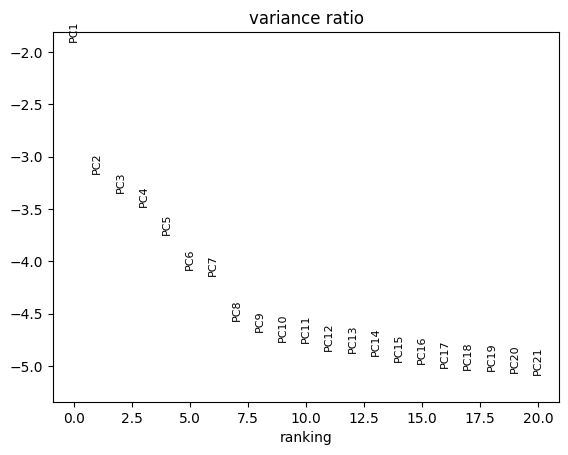

In [13]:
sc.tl.pca(adata, svd_solver='arpack', use_highly_variable = True)

sc.pl.pca_variance_ratio(adata, log=True, n_pcs = 20) # visualize PCA variance explained

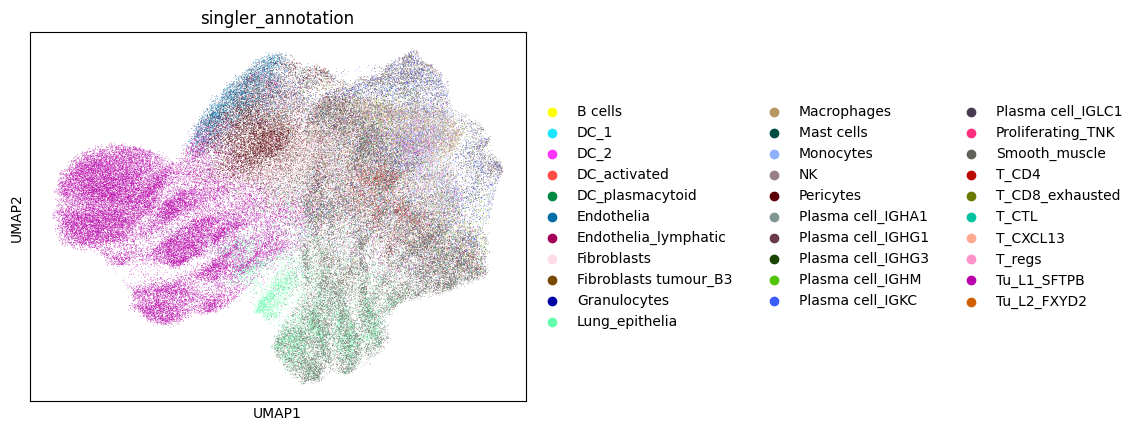

In [14]:
sc.pp.neighbors(adata, n_neighbors=5, n_pcs=20)
sc.tl.umap(adata)

# plot pre-annotated cell types
sc.pl.umap(adata, color=['singler_annotation'])

## 3.2 Ligand-Receptor Inference

### 3.2.1 Environment Setup

In [17]:
import os
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import matplotlib

import scanpy as sc
import cell2cell as c2c

import liana as li
import plotnine as p9

from tqdm.auto import tqdm

In [9]:
import warnings
warnings.filterwarnings('ignore')

In [33]:
#Take out of storage the large anndata file if it works 

In [34]:
adata

AnnData object with n_obs × n_vars = 121892 × 284
    obs: 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'sample_id', 'sum', 'detected', 'subsets_Mito_sum', 'subsets_Mito_detected', 'subsets_Mito_percent', 'total', 'libsize_drop', 'sizeFactor', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.8', 'seurat_clusters', 'singler_annotation', 'ident', 'sample'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', 'pca', 'neighbors', 'umap', 'singler_annotation_colors'
    obsm: 'PCA', 'TSNE', 'UMAP', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'logcounts'
    obsp: 'distances', 'connectivities'

### 3.2.5 Scoring Functions

#### 3.2.5.9 Score Distributions

In [18]:
#To run Liana on only one of the samples in our large Anndata object
# pick a sample to infer the communication scores for
sample_name = 'adata_L1_1_LT'
sadata = adata[adata.obs['sample']==sample_name]
sadata

View of AnnData object with n_obs × n_vars = 72666 × 284
    obs: 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'sample_id', 'sum', 'detected', 'subsets_Mito_sum', 'subsets_Mito_detected', 'subsets_Mito_percent', 'total', 'libsize_drop', 'sizeFactor', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.8', 'seurat_clusters', 'singler_annotation', 'ident', 'sample'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', 'neighbors', 'umap', 'singler_annotation_colors', 'seurat_clusters_colors', 'log1p', 'pca'
    obsm: 'PCA', 'TSNE', 'UMAP', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'logcounts'
    obsp: 'distances', 'connectivities'

In [19]:
%%time
li.method.rank_aggregate(sadata,
                           groupby='singler_annotation',
                           resource_name = 'consensus',
                           expr_prop=0.1, # must be expressed in expr_prop fraction of cells
                           min_cells = 5,
                           n_perms = 1000,
                           use_raw = False, # run on log- and library-normalized counts
                           verbose = True,
                           inplace = True
                          )

Using `.X`!
13 features of mat are empty, they will be removed.
Using resource `consensus`.
0.94 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 72666 samples and 271 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB


100%|██████████| 1000/1000 [00:12<00:00, 77.49it/s]


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR
Running CellChat


100%|██████████| 1000/1000 [00:47<00:00, 21.13it/s]


CPU times: user 1min 3s, sys: 144 ms, total: 1min 3s
Wall time: 1min 4s


In [23]:
liana_res = sadata.uns['liana_res'].copy()
#liana_res.to_csv(os.path.join(output_folder, sample_name + '_aggregate_scores.csv'))
# only keep those that are not liana's ranks
liana_res.head()

,source,target,ligand_complex,receptor_complex,lr_means,cellphone_pvals,expr_prod,scaled_weight,lr_logfc,spec_weight,lrscore,lr_probs,cellchat_pvals,specificity_rank,magnitude_rank
925,Plasma cell_IGHM,Lung_epithelia,ADAM17,MUC1,4.967675,0.0,22.936234,0.862021,1.714296,0.018867,0.868429,0.394844,0.0,0.018618,4.255585e-08
952,Plasma cell_IGHM,Tu_L1_SFTPB,ADAM17,MUC1,4.872006,0.0,22.238235,0.829657,2.231416,0.018293,0.866653,0.380979,0.0,0.017011,3.400926e-07
316,Endothelia,B cells,CD34,SELL,4.107778,0.0,16.292383,2.271369,3.700898,0.041536,0.847630,0.377026,0.0,0.000172,1.146617e-06
456,Fibroblasts tumour_B3,Lung_epithelia,ADAM17,MUC1,3.998949,0.0,10.754773,0.428122,1.281399,0.008847,0.818832,0.178268,0.0,0.065982,3.076496e-05
196,DC_2,T_regs,CD86,CTLA4,3.925214,0.0,13.235380,3.161279,4.350503,0.055950,0.833720,0.170189,0.0,0.000011,4.215731e-05


In [41]:
# convert to long format by index, and each score and value in different columns
liana_res = liana_res.loc[:, liana_res.columns[~liana_res.columns.str.contains(pat = 'rank')]]
liana_res = liana_res.melt(id_vars=['source', 'target', 'ligand_complex', 'receptor_complex'], var_name='score', value_name='value')

liana_res['score'] = liana_res['score'].astype('category')

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


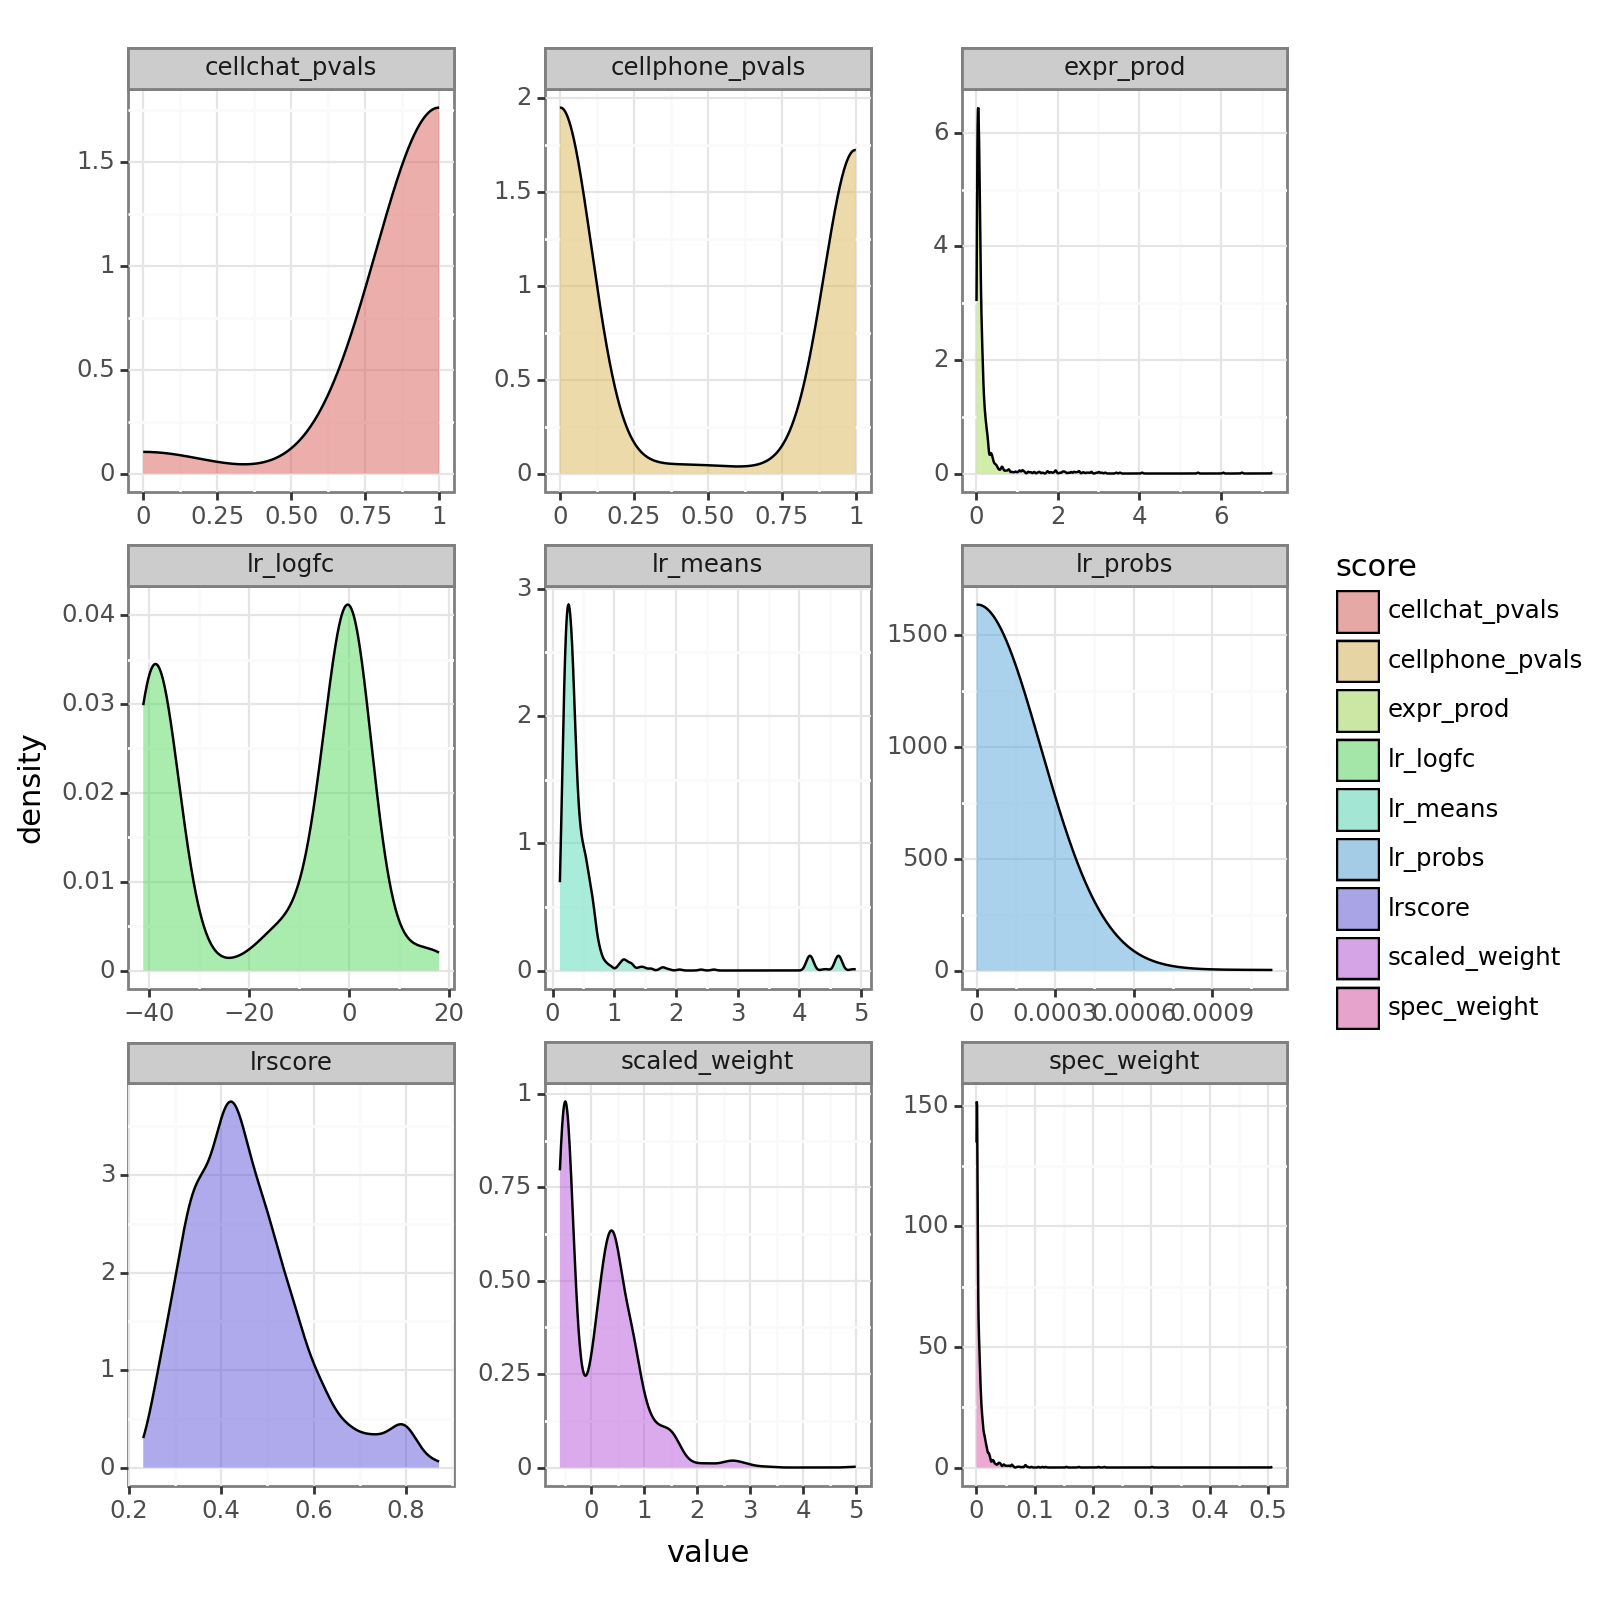

<Figure Size: (800 x 800)>

In [42]:
(p9.ggplot(liana_res, p9.aes(x='value', fill='score')) +
 p9.geom_density(alpha=0.5) +
 p9.facet_wrap('~score', scales='free') +
 p9.theme_bw() +
 p9.theme(figure_size=(8, 8))
 )

In [105]:
#Checking the correlation between different Specificity scores : Here in order those of CellPhoneDB, NATMI, CellChat, Connectome, log2FC, specificity_rank, Geometric Mean	

In [24]:
specificity_scores = ['cellphone_pvals', 'spec_weight', 'cellchat_pvals', 'scaled_weight', 'lr_logfc', 'specificity_rank']
liana_corr = sadata.uns['liana_res'].copy()[specificity_scores].corr(method = 'spearman')

In [29]:
liana_corr

,cellphone_pvals,spec_weight,cellchat_pvals,scaled_weight,lr_logfc,specificity_rank
cellphone_pvals,1.000000,-0.826159,0.184438,-0.884709,-0.881040,0.768674
spec_weight,-0.826159,1.000000,-0.339879,0.923826,0.911099,-0.853554
cellchat_pvals,0.184438,-0.339879,1.000000,-0.266667,-0.252754,0.379932
scaled_weight,-0.884709,0.923826,-0.266667,1.000000,0.961800,-0.875570
lr_logfc,-0.881040,0.911099,-0.252754,0.961800,1.000000,-0.874287
specificity_rank,0.768674,-0.853554,0.379932,-0.875570,-0.874287,1.000000


In [97]:
df_=sadata.uns['liana_res'][specificity_scores].copy()
D=c2c.clustering.compute_distance(df_.T,metric='correlation')
D=pd.DataFrame(D,index=df_.T.index,columns=df_.T.index)

In [108]:
#test for magnitude scores
magnitude_scores = ['lr_means', 'expr_prod', 'lrscore', 'lr_probs', 'expr_prod']
liana_corr = sadata.uns['liana_res'].copy()[magnitude_scores].corr(method = 'spearman')

Interaction space detected as a distance matrix


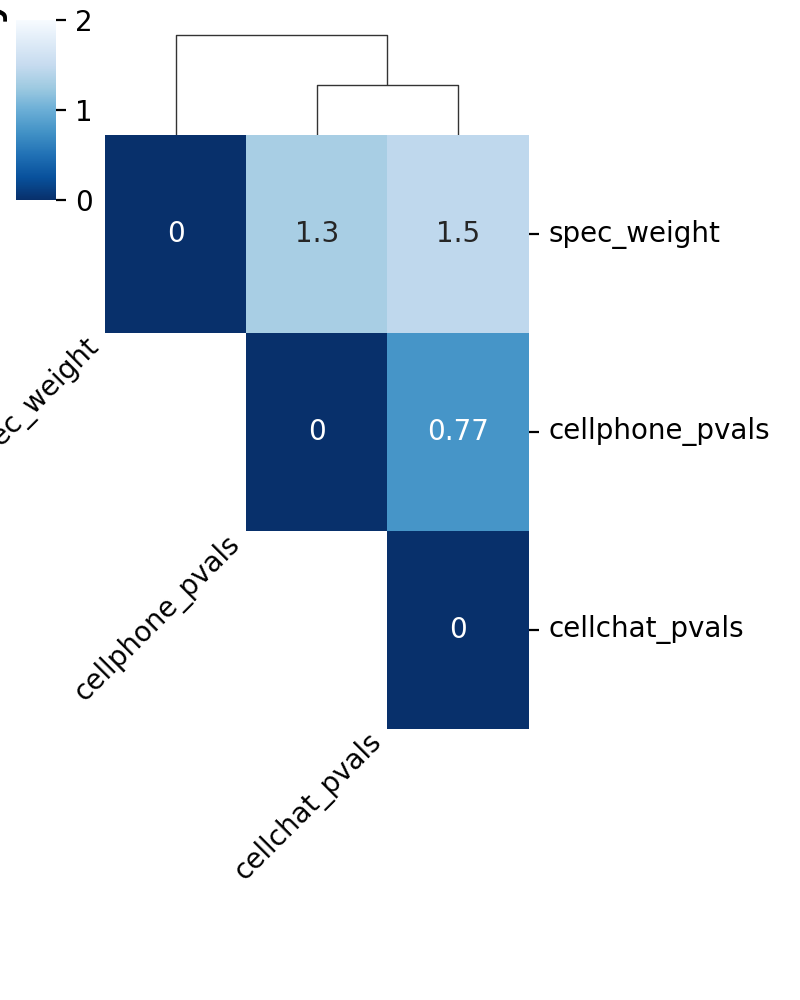

In [99]:
cm = c2c.plotting.clustermap_cci(D,
                                 method='ward',
                                 optimal_leaf=True,
                                 metadata=None,
                                 title='',
                                 cbar_title='Similarity',
                                 cmap='Blues_r',
                                 vmax=2.,
#                                  vmin=0.,
                                 annot=True,
                                 dendrogram_ratio=0.15,
                                figsize=(4,5))

###### 3.2.5.9 a) Score Distributions Adapting the matrices for p values 

Using sdata that only has one of the samples treated.
- make sure the p values seam reasonible -> Print out the plots with inferior p values for significance (done in the next b))
- invert them
- then re-run the correlation matrix
- then follows ChatG’s code for printing the heat map.


In [91]:
#inverting the p vals and saving them in the column
sadata.uns['liana_res']['cellchat_pvals_inverted'] = 1 / (sadata.uns['liana_res']['cellchat_pvals'] + 0.00000001)
sadata.uns['liana_res']['cellphone_pvals_inverted'] = 1 / (sadata.uns['liana_res']['cellphone_pvals'] + 0.00000001)
sadata.uns['liana_res']['specificity_rank_inverted'] = 1 / (sadata.uns['liana_res']['specificity_rank'] - 0.00000000001)
sadata.uns['liana_res']

,source,target,ligand_complex,receptor_complex,lr_means,cellphone_pvals,expr_prod,scaled_weight,lr_logfc,spec_weight,lrscore,lr_probs,cellchat_pvals,specificity_rank,magnitude_rank,cellchat_pvals_inverted,cellphone_pvals_inverted,magnitude_rank_inverted,specificity_rank_inverted
925,Plasma cell_IGHM,Lung_epithelia,ADAM17,MUC1,4.967675,0.0,22.936234,0.862021,1.714296,0.018867,0.868429,0.394844,0.0,0.018618,4.255585e-08,100000000.0,100000000.0,2.349854e+07,53.711486
952,Plasma cell_IGHM,Tu_L1_SFTPB,ADAM17,MUC1,4.872006,0.0,22.238235,0.829657,2.231416,0.018293,0.866653,0.380979,0.0,0.017011,3.400926e-07,100000000.0,100000000.0,2.940376e+06,58.785813
316,Endothelia,B cells,CD34,SELL,4.107778,0.0,16.292383,2.271369,3.700898,0.041536,0.847630,0.377026,0.0,0.000172,1.146617e-06,100000000.0,100000000.0,8.721310e+05,5824.172935
456,Fibroblasts tumour_B3,Lung_epithelia,ADAM17,MUC1,3.998949,0.0,10.754773,0.428122,1.281399,0.008847,0.818832,0.178268,0.0,0.065982,3.076496e-05,100000000.0,100000000.0,3.250451e+04,15.155722
196,DC_2,T_regs,CD86,CTLA4,3.925214,0.0,13.235380,3.161279,4.350503,0.055950,0.833720,0.170189,0.0,0.000011,4.215731e-05,100000000.0,100000000.0,2.372068e+04,91902.979940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1072,T_CD4,Fibroblasts,FASLG,FAS,1.043718,0.0,0.887039,0.578422,2.103466,0.008490,0.564845,0.000000,1.0,0.210440,1.000000e+00,1.0,100000000.0,1.000000e+00,4.751954
1073,T_CD4,Fibroblasts tumour_B3,ADAM17,MUC1,1.070444,1.0,1.130000,-0.603956,-1.146843,0.000930,0.594329,0.000000,1.0,1.000000,1.000000e+00,1.0,1.0,1.000000e+00,1.000000
1074,T_CD4,Fibroblasts tumour_B3,FASLG,FAS,0.958947,0.0,0.786343,0.531844,2.155182,0.007526,0.549982,0.000000,1.0,0.210440,1.000000e+00,1.0,100000000.0,1.000000e+00,4.751954
1264,T_regs,Plasma cell_IGKC,CD86,CD28,0.881741,0.0,0.713117,0.491235,1.719162,0.003051,0.537859,0.000000,1.0,0.997528,1.000000e+00,1.0,100000000.0,1.000000e+00,1.002478


In [92]:
# Re run the correlation matrix
specificity_scores = ['cellphone_pvals_inverted', 'spec_weight', 'cellchat_pvals_inverted', 'scaled_weight', 'lr_logfc', 'specificity_rank_inverted']
liana_corr = sadata.uns['liana_res'].copy()[specificity_scores].corr(method = 'spearman')
liana_corr

,cellphone_pvals_inverted,spec_weight,cellchat_pvals_inverted,scaled_weight,lr_logfc,specificity_rank_inverted
cellphone_pvals_inverted,1.000000,0.826159,0.184438,0.884709,0.881040,0.768674
spec_weight,0.826159,1.000000,0.339879,0.923826,0.911099,0.853554
cellchat_pvals_inverted,0.184438,0.339879,1.000000,0.266667,0.252754,0.379932
scaled_weight,0.884709,0.923826,0.266667,1.000000,0.961800,0.875570
lr_logfc,0.881040,0.911099,0.252754,0.961800,1.000000,0.874287
specificity_rank_inverted,0.768674,0.853554,0.379932,0.875570,0.874287,1.000000


In [ ]:
#Run with the Heat Map -> 

###### 3.2.5.9  b) Checking out p values that are too weak

In [61]:
font = matplotlib.font_manager.FontProperties(weight='bold', size=7)
for ax in [cm.ax_heatmap, cm.ax_cbar]:
    for tick in ax.get_xticklabels():
        tick.set_fontproperties(font)
    for tick in ax.get_yticklabels():
        tick.set_fontproperties(font)

    text = ax.yaxis.label
    text.set_font_properties(font)

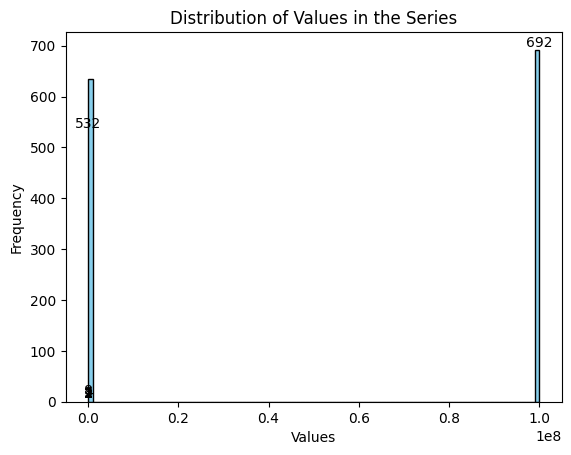

In [85]:
import pandas as pd
import matplotlib.pyplot as plt

# Create series -> Select ony by one the different specificity scores. s
data = sadata.uns['liana_res']['cellphone_pvals_inverted']

# Plot histogram
plt.hist(data, bins=100, color='skyblue', edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Distribution of Values in the Series')

# Add frequency labels atop each bin
for i, freq in enumerate(data.value_counts()):
    plt.text(data.value_counts().index[i], freq, str(freq), ha='center', va='bottom')

plt.show()


In [ ]:
#Give a total sum of the values in the previous matrix : 

#### 3.2.5.11 Single-Sample Dotplot

In [1]:
#Need to chose some genes and cells of interest -> Daria VISTA. 


li.pl.dotplot(
    adata=sadata,
    colour="magnitude_rank",
    size="specificity_rank",
    inverse_colour=True,  # we inverse sign since we want small p-values to have large sizes
    inverse_size=True,
    # We choose only the cell types which we wish to plot
    source_labels=["B", "pDC", "Macrophages"],
    target_labels=["T", "Mast", "pDC", "NK"],
    # since the rank_aggregate can also be interpreted as a probability distribution
    # we can again filter them according to their specificity significance
    # yet here the interactions are filtered according to
    # how consistently highly-ranked is their specificity across the methods
    filterby="specificity_rank",
    filter_lambda=lambda x: x <= 0.05,
    # again, we can also further order according to magnitude
    orderby="magnitude_rank",
    orderby_ascending=True,  # prioritize those with lowest values
    top_n=20,  # and we want to keep only the top 20 interactions
    figure_size=(9, 5),
    size_range=(1, 6),
)

IndentationError: unexpected indent (264680105.py, line 5)

In [ ]:
#### 3.2.5.11 Single-Sample Dotplot

# 4. Robustness analyis on all samples. 